In [27]:
%pip install xgboost


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
import yaml

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, r2_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
SUBSET = 0
EPOCH = 32
TEST_SIZE = 0.25

with open("config.yml", 'r') as f:
    config = yaml.safe_load(f)

if config is not None:
    subset_id = int(config["variables"]["dataset"]["subset"])
    PATH_TO_SUBSET = Path(config["paths"]["local"][f"subset_{SUBSET}_directory"])

    if f"subset_{SUBSET}_continuous_testing_directory" in config["paths"]["local"]:
        PATH_TO_SUBSET_CONT_TESTING = Path(
            config["paths"]["local"][f"subset_{SUBSET}_continuous_testing_directory"])
    else:
        PATH_TO_SUBSET_CONT_TESTING = PATH_TO_SUBSET
    NET_TYPE = config["variables"]["models"]["net_type"]
    IDENTIFIER = config["variables"]["models"]["net_identifier"]
else:
    subset_id = 1
    PATH_TO_SUBSET = Path(__file__).parent.joinpath("data", "subset-1")
    PATH_TO_SUBSET_CONT_TESTING = PATH_TO_SUBSET
    NET_TYPE = "UResIncNet"
    IDENTIFIER = "ks3-depth8-strided-0"

PATH_TO_META_MODEL = PATH_TO_SUBSET_CONT_TESTING.joinpath("meta-model", f"trainedOn-subset-{subset_id}",
                                                            str(NET_TYPE), str(IDENTIFIER), f"epoch-{EPOCH}")

print(NET_TYPE)
print(IDENTIFIER)

UResIncNet
ks3-depth8-layers1-strided-weightedLoss-0


(1756, 550)


<Figure size 3000x3000 with 0 Axes>

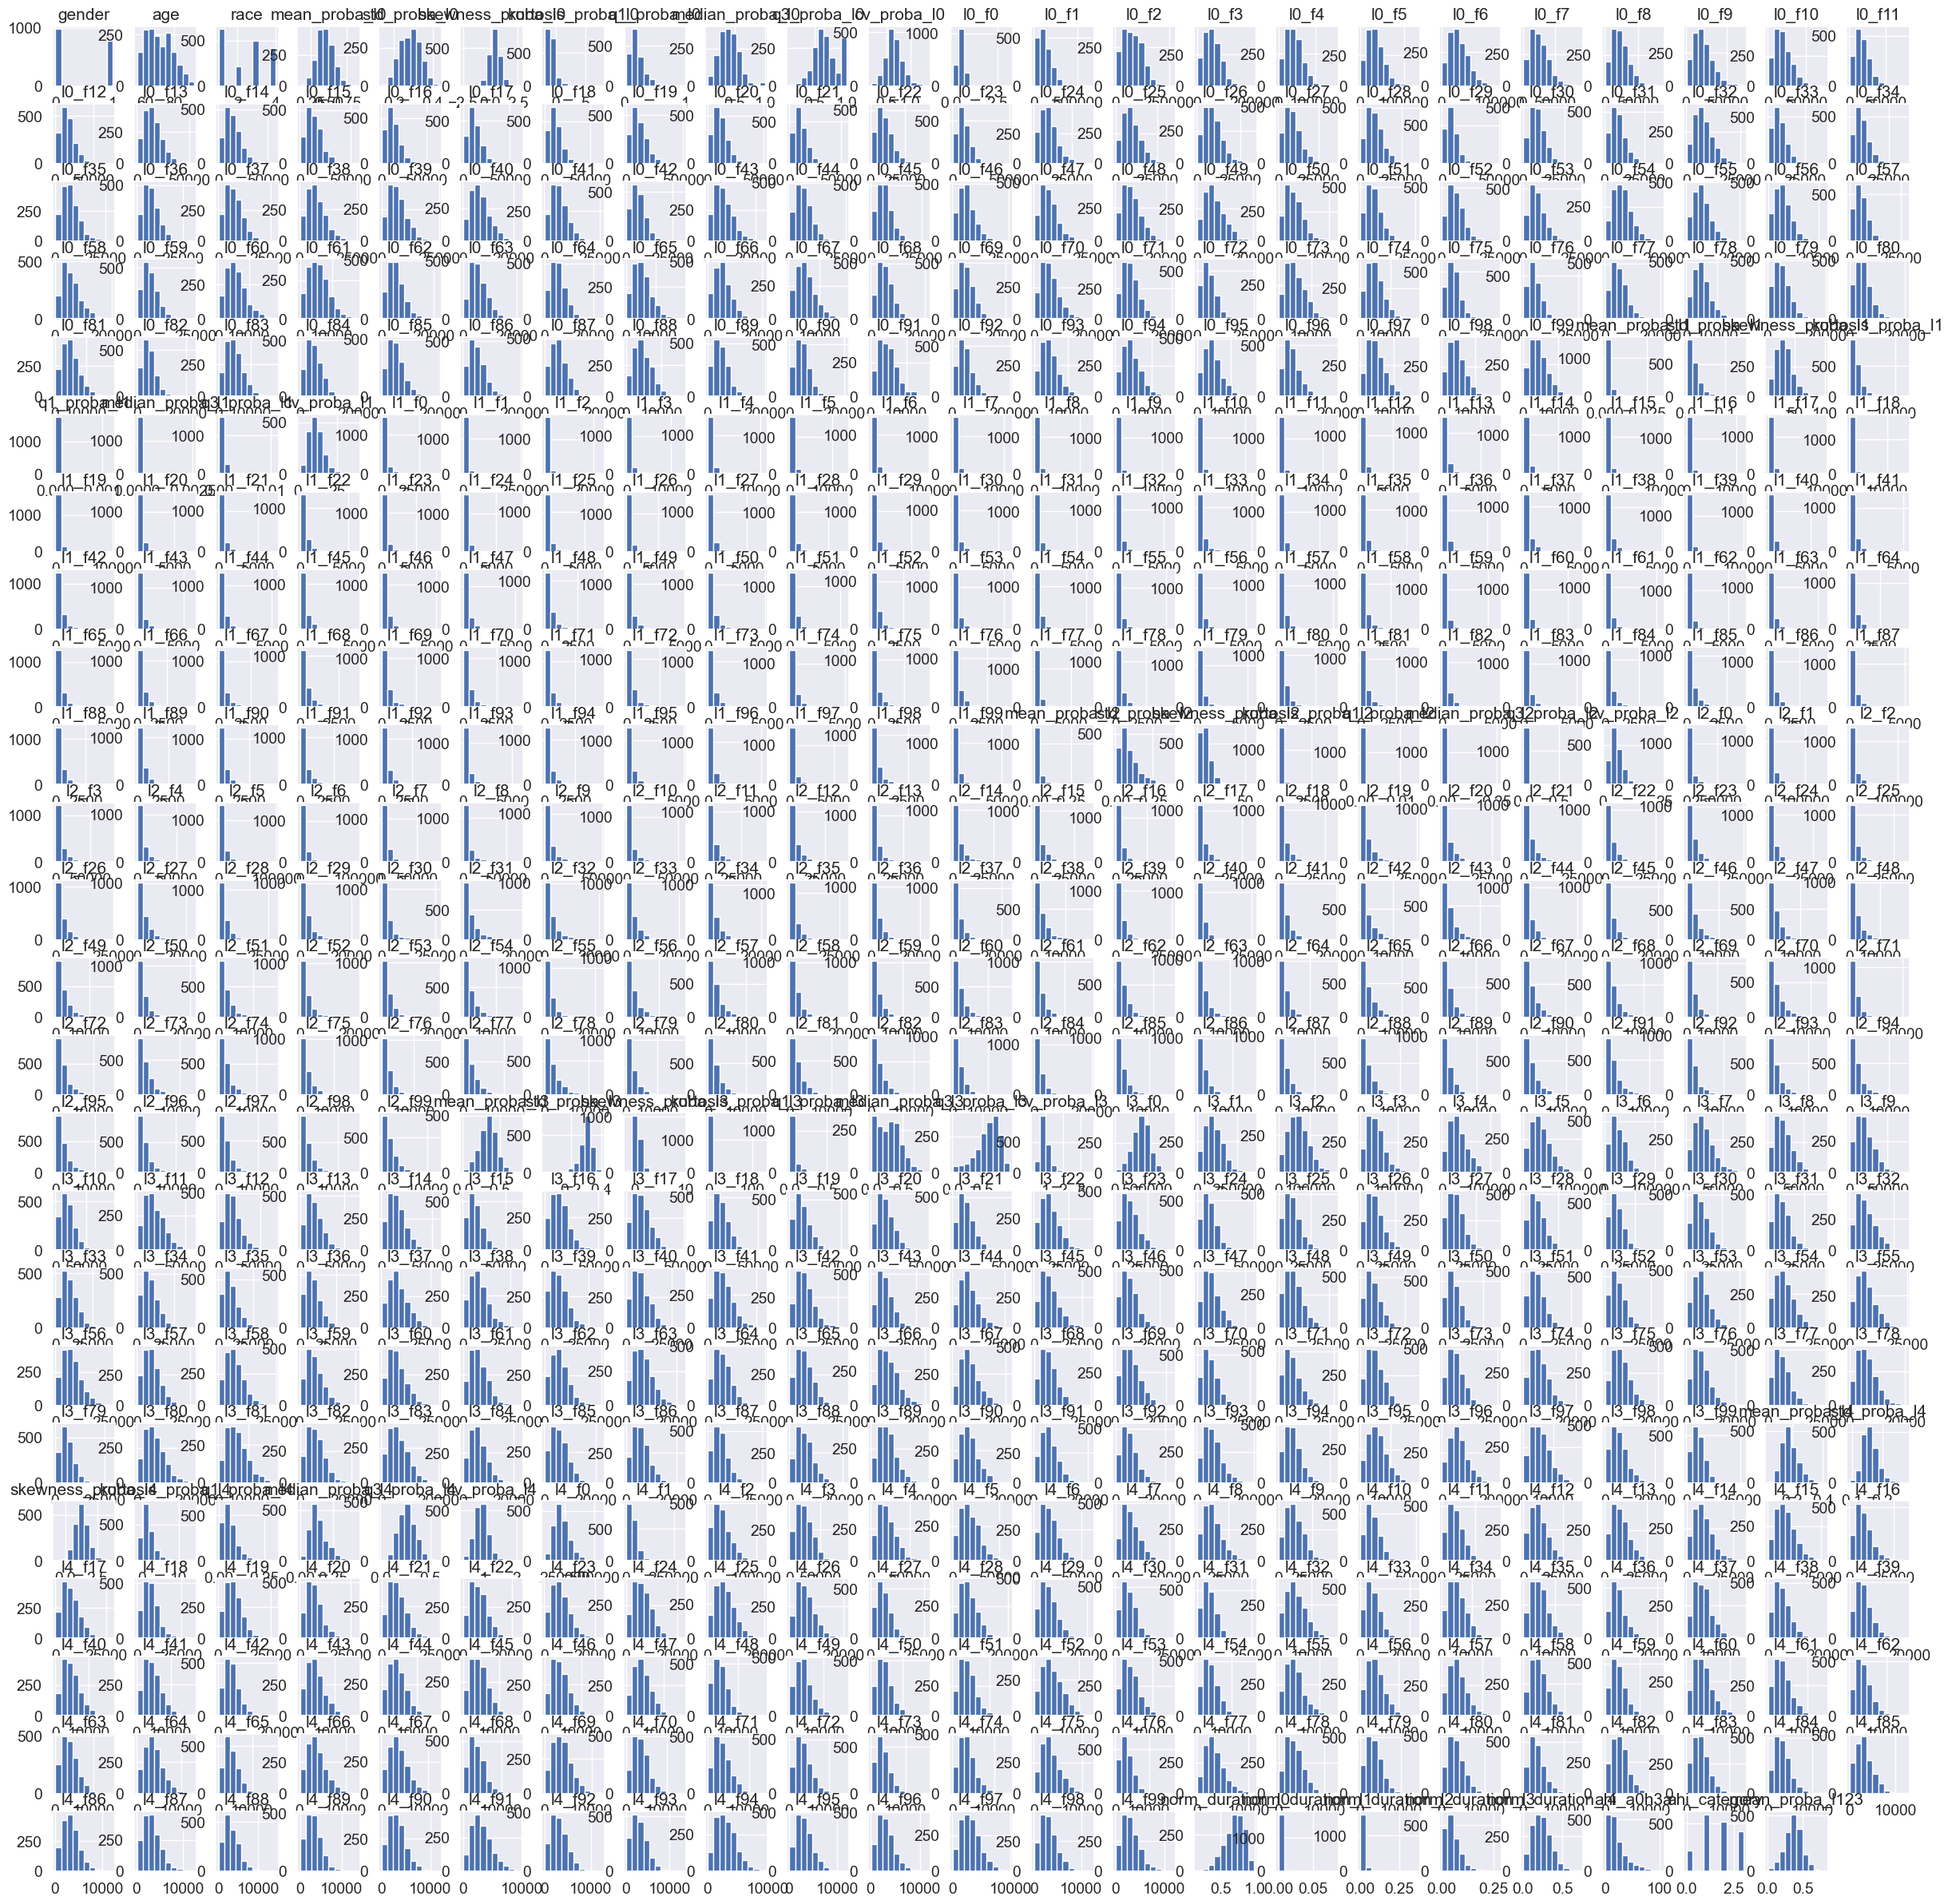

In [30]:
meta_df = pd.read_csv(PATH_TO_META_MODEL.joinpath("meta_df.csv"), index_col=0)
print(meta_df.shape)


meta_df["mean_proba_l123"] = meta_df["mean_proba_l1"] + meta_df["mean_proba_l2"]+ meta_df["mean_proba_l3"]

out_columns = ["norm_duration_l0", "norm_duration_l1", "norm_duration_l2", "norm_duration_l3", "norm_duration_l4",
             "ahi_a0h3a", "ahi_category"]
in_columns = [c for c in meta_df.columns if c not in out_columns]

fourier_columns = [c for c in in_columns if "_f" in c and 'l' in c and c not in out_columns]
stat_columns = [c for c in in_columns if c not in fourier_columns]

fig = plt.figure(figsize=(30,30))
meta_df[stat_columns & out_columns].hist(figsize=(30,30))
plt.show()


Top 8 features with largest absolute (positive or negative) correlation with ahi_category: ['std_proba_l4' 'q3_proba_l4' 'std_proba_l2' 'mean_proba_l4' 'l4_f0'
 'cv_proba_l2' 'skewness_proba_l2' 'l2_f71']


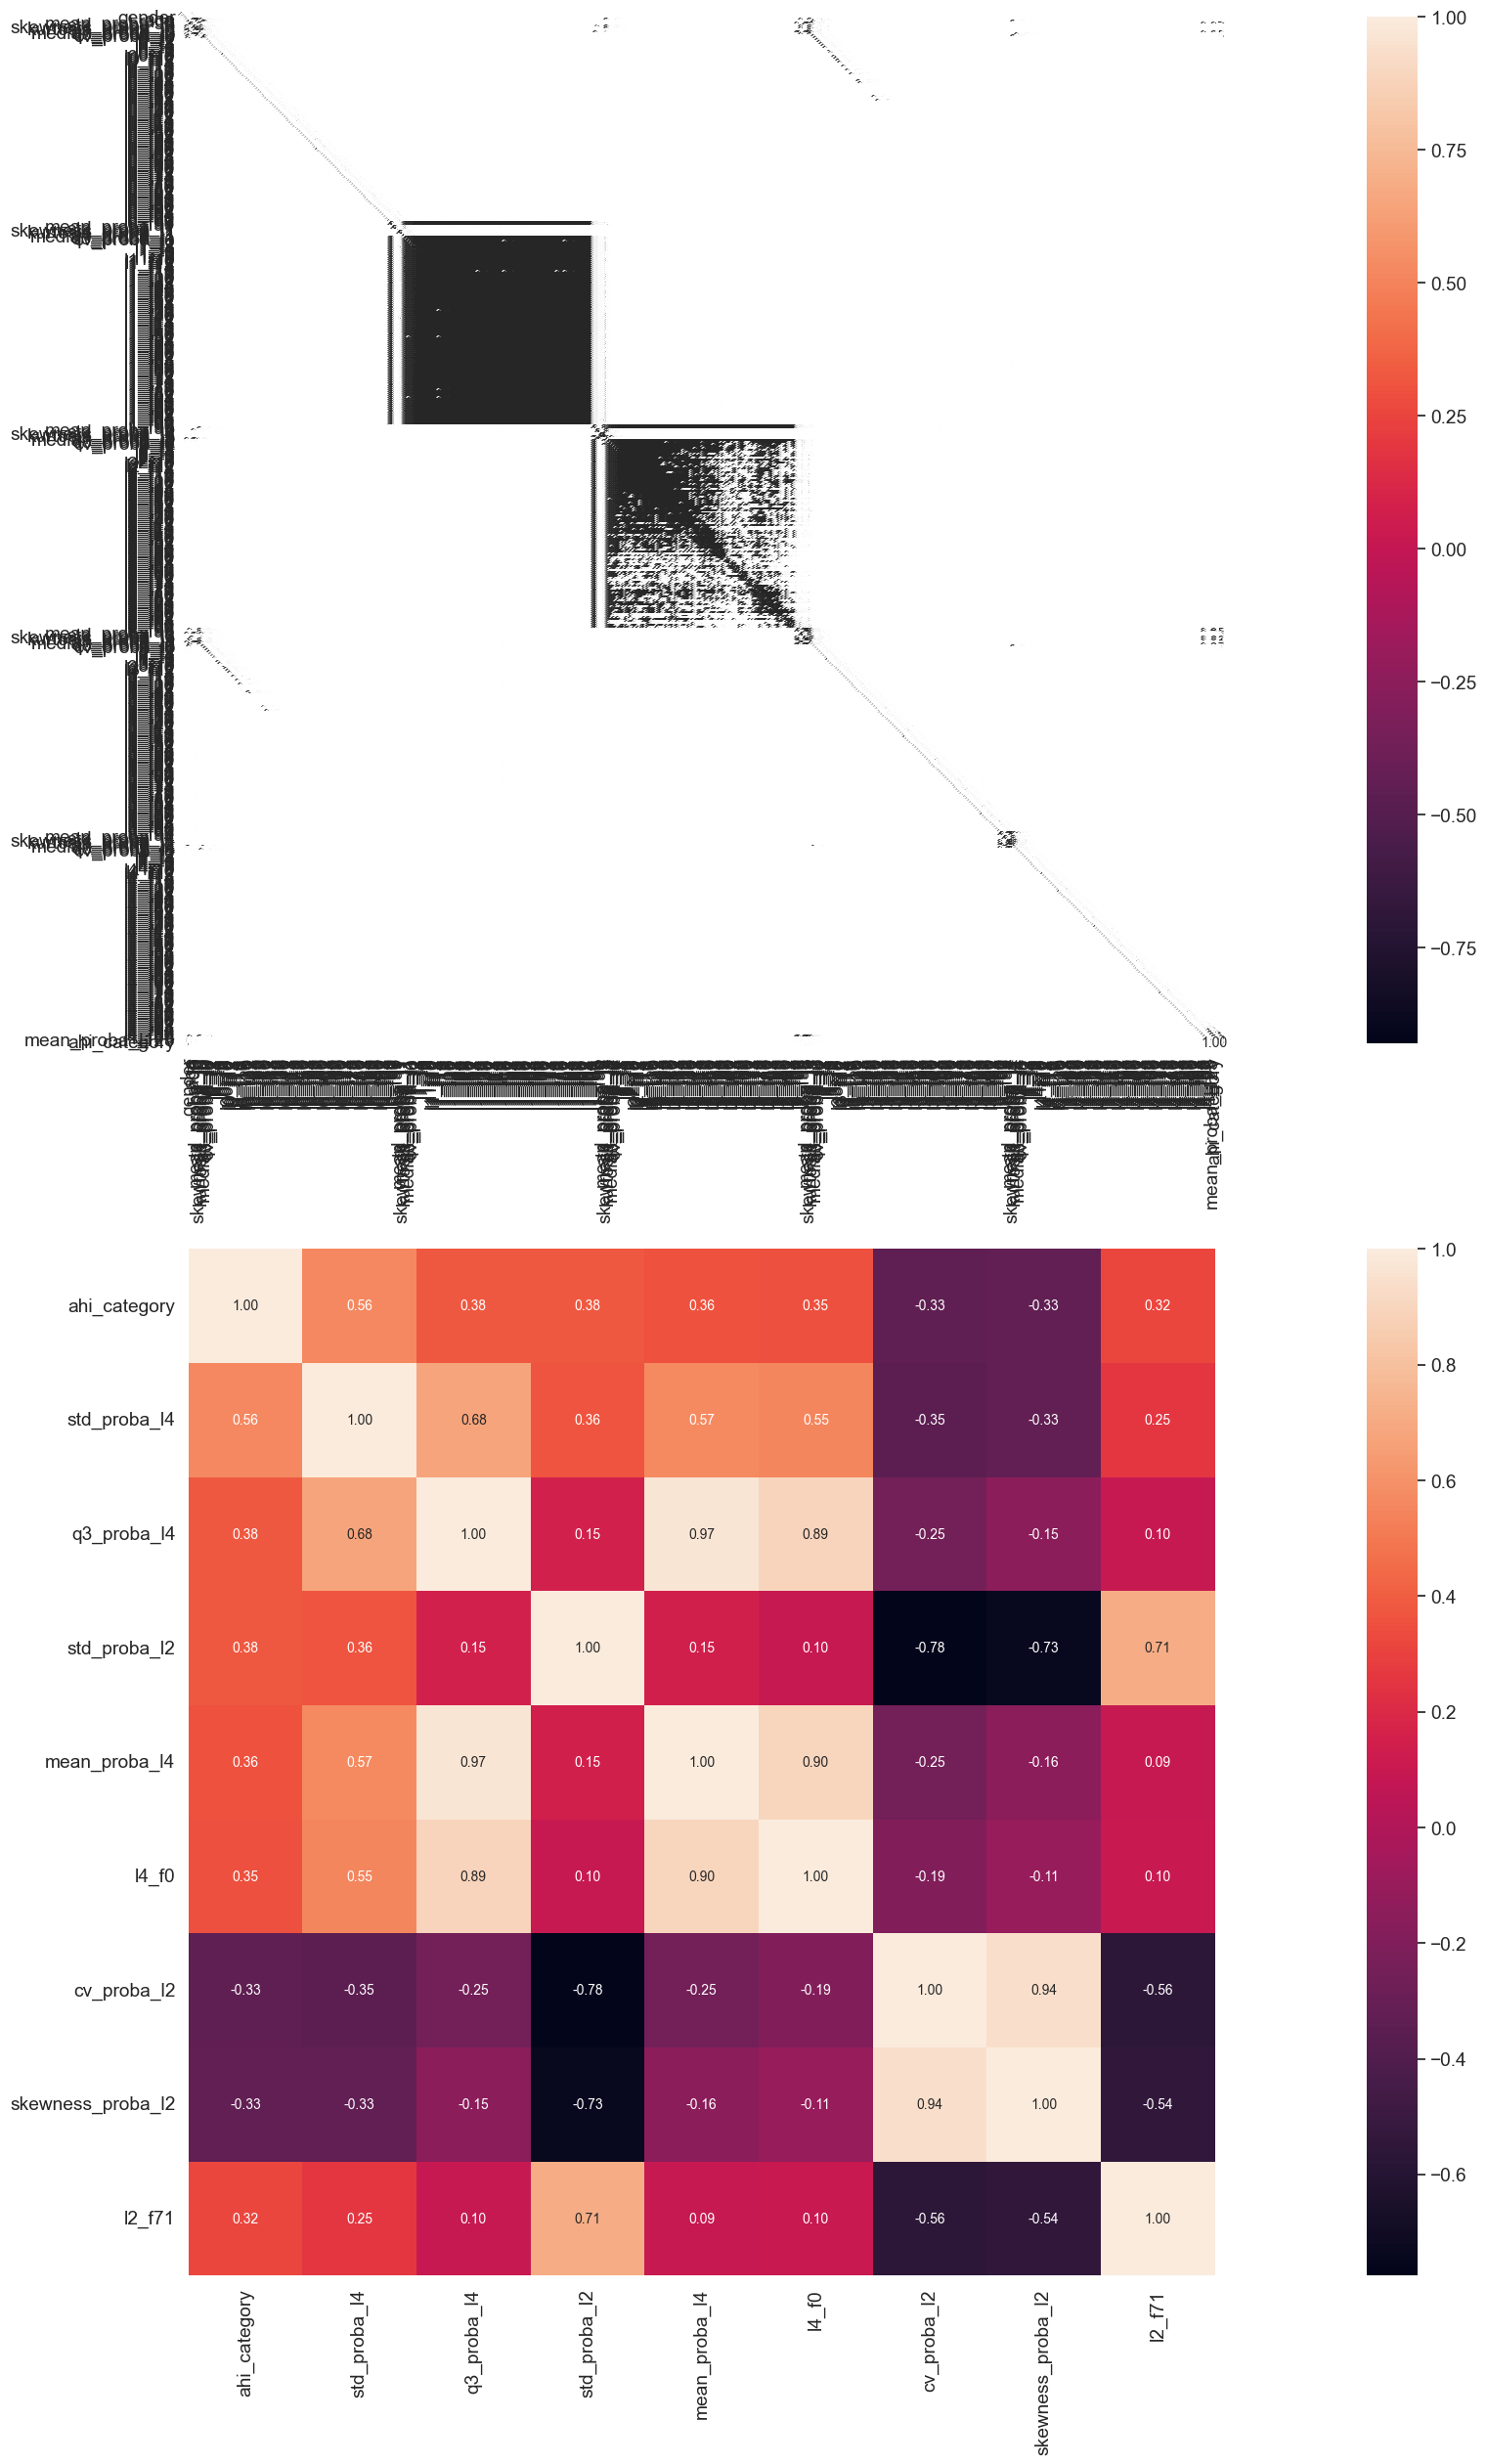

In [31]:
def plot_correl_matrix(df, target, k=8):
    # k = features to select
    corrmat = df.corr()
    sns.set(font_scale=1.25)
    if k>0 and k<len(df.columns):
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(40,30))
        
        sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=df.columns.values, xticklabels=df.columns.values, ax=ax[0])

        largest_abs_corr_cols = corrmat.abs().nlargest(k+1, target)[target].index
        cm = np.corrcoef(df[largest_abs_corr_cols].values.T)

        sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=largest_abs_corr_cols.values, xticklabels=largest_abs_corr_cols.values, ax=ax[1]) 

        largest_abs_corr_cols = np.delete(largest_abs_corr_cols.values, 0) # remove target
        print(f"Top {k} features with largest absolute (positive or negative) correlation with {target}: {largest_abs_corr_cols}")
    else:
        sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=df.columns.values, xticklabels=df.columns.values)

target="ahi_category"
plot_correl_matrix(meta_df[[*in_columns, target]], target=target)

In [32]:
meta_train_df, meta_test_df = train_test_split(meta_df, test_size=TEST_SIZE, random_state=33,
                                                shuffle=True, stratify=meta_df["ahi_category"])

X_train_df: pd.DataFrame = meta_train_df[in_columns]
Y_train_df: pd.DataFrame = meta_train_df[out_columns]
X_test_df: pd.DataFrame = meta_test_df[in_columns]
Y_test_df: pd.DataFrame = meta_test_df[out_columns]

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

Y_train_clas = Y_train_df["ahi_category"].to_numpy().ravel()
Y_test_clas = Y_test_df["ahi_category"].to_numpy().ravel()

Y_train_reg = Y_train_df.drop("ahi_category", axis=1, inplace=False).to_numpy()
Y_test_reg = Y_test_df.drop("ahi_category", axis=1, inplace=False).to_numpy()

## Standardization:

In [33]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Classification

### Model Selection

In [34]:
models = [LogisticRegression(random_state=33, solver="newton-cg"), RandomForestClassifier(random_state=33), SVC(random_state=33), XGBClassifier(seed=33)]

for model in models:
    scores = cross_validate(estimator=model, X=X_train, y=Y_train_clas, scoring="accuracy", cv=5)
    acc = np.mean(scores["test_score"])
    print(f"{model} -> {100*acc:2.2f}%")

LogisticRegression(random_state=33, solver='newton-cg') -> 41.08%
RandomForestClassifier(random_state=33) -> 47.38%
SVC(random_state=33) -> 45.03%
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) -> 46.70%


#### Logistic

In [35]:
model = LogisticRegression(random_state=33)

parameters = {'multi_class':['auto'],
              'penalty': ['l1', 'l2'],
              'C': np.linspace(0.2,1.0, num=10, endpoint=True),
              'solver': ['liblinear', 'newton-cg', 'saga']}
clf = GridSearchCV(model, parameters, cv=5, scoring="accuracy")
clf.fit(X_train, Y_train_clas)
print(clf.best_score_)
clf.best_params_

g:\filip\Documents\Data Science Projects\Thesis\apnea-ppg\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
g:\filip\Documents\Data Science Projects\Thesis\apnea-ppg\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
g:\filip\Documents\Data Science Projects\Thesis\apnea-ppg\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
g:\filip\Documents\Data Science Projects\Thesis\apnea-ppg\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
g:\filip\Documents\Data Science Projects\Thesis\apnea-ppg\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: T

0.43738621961055413


{'C': 0.2, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'liblinear'}

In [36]:
best_params_ = {'C': 0.6631578947368422,
 'multi_class': 'auto',
 'penalty': 'l1',
 'solver': 'liblinear'}

### SVC

In [37]:
model = SVC(random_state=33)

parameters = {'degree': [2, 3, 4],
              'gamma': ["scale", "auto"],
              'C': np.linspace(0.1,1.0, num=10, endpoint=True),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
clf = GridSearchCV(model, parameters, cv=5, scoring="accuracy")
clf.fit(X_train, Y_train_clas)
print(clf.best_score_)
print(clf.best_params_)

0.4540788109229174
{'C': 0.9, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


In [38]:
rf_clas = RandomForestClassifier(random_state=33)

parameters = {'n_estimators':[100], 
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth':[5, 7, 10],
              'min_samples_split': [2, 3, 4, 5],
              'min_samples_leaf': [1, 2, 3, 4],
              'max_features': ("sqrt", 'log2')}
clf = GridSearchCV(rf_clas, parameters, cv=5, scoring="accuracy")
clf.fit(X_train, Y_train_clas)

print(clf.best_score_)
best_params = clf.best_params_
print(best_params)

0.485182624726351
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}


In [39]:
print(best_params)

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}


0.44419134396355353


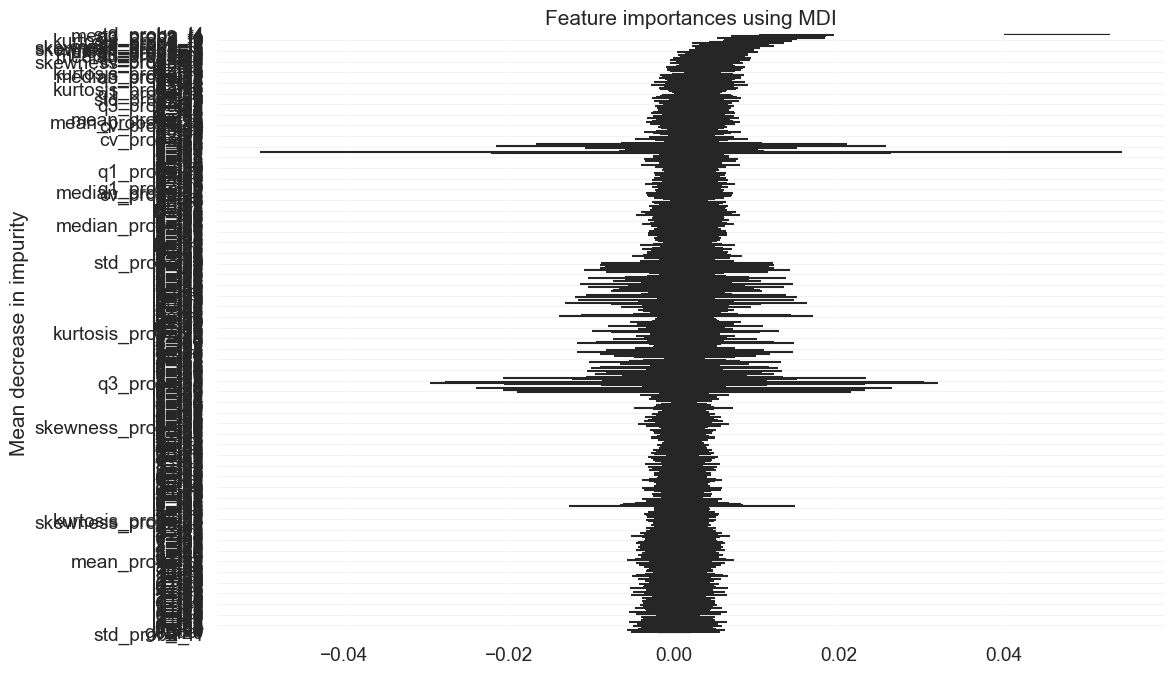

In [40]:
if False:
    params = {'criterion': 'entropy',
    'max_depth': 7,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 4,
    'n_estimators': [100, 200, 300, 400, 500]}

    clf = GridSearchCV(rf_clas, parameters, cv=5, scoring="accuracy")
    clf.fit(X_train, Y_train_clas)

    best_params = clf.best_params_
else:
    best_params = { 'criterion': 'entropy',
                    'max_depth': 7,
                    'max_features': 'sqrt',
                    'min_samples_leaf': 1,
                    'min_samples_split': 4,
                    'n_estimators': 100}    

rf_clas = RandomForestClassifier(**best_params, random_state=33)
rf_clas.fit(X_train, Y_train_clas)

# print(np.mean(cross_validate(rf_clas, X_train, Y_train_clas, cv=5)["test_score"]))
print(accuracy_score(rf_clas.predict(X_test), Y_test_clas))

importances = rf_clas.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clas.estimators_], axis=0)
forest_importances = pd.Series(rf_clas.feature_importances_, index=in_columns).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(12,7))
forest_importances.plot.barh(xerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Regression

In [41]:
Y_train_reg.shape

(1317, 6)

In [42]:
models = {"lr": LinearRegression(), "ridge": Ridge(), "svr": SVR(), "rf": RandomForestRegressor(random_state=33), "xgb": XGBRegressor(seed=33)}

cv_splitter = [(train_indices, validation_indices) for (train_indices, validation_indices) in StratifiedKFold(n_splits=5).split(X_train, y=Y_train_clas)]

for name, model in models.items():
    print(f"Model: {name}")
    for i, var in enumerate(out_columns[0:6]):
        scores = cross_validate(estimator=model, X=X_train, y=Y_train_reg[:,i], scoring='r2', cv=cv_splitter)["test_score"]
        print(f"Target: {var} -> Mean score: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}, CV: {100*np.std(scores)/abs(np.mean(scores)):2.2f}%")

Model: lr
Target: norm_duration_l0 -> Mean score: -0.1117, Std: 0.1579, CV: 141.38%
Target: norm_duration_l1 -> Mean score: -1.9331, Std: 1.6382, CV: 84.75%
Target: norm_duration_l2 -> Mean score: -1.4311, Std: 1.6987, CV: 118.70%
Target: norm_duration_l3 -> Mean score: -1.8785, Std: 1.1545, CV: 61.46%
Target: norm_duration_l4 -> Mean score: -0.0938, Std: 0.0569, CV: 60.69%
Target: ahi_a0h3a -> Mean score: -0.0105, Std: 0.1474, CV: 1401.37%
Model: ridge
Target: norm_duration_l0 -> Mean score: -0.0783, Std: 0.1565, CV: 199.77%
Target: norm_duration_l1 -> Mean score: -1.7148, Std: 1.3132, CV: 76.58%
Target: norm_duration_l2 -> Mean score: -1.1515, Std: 1.2661, CV: 109.95%
Target: norm_duration_l3 -> Mean score: -1.5787, Std: 0.8560, CV: 54.22%
Target: norm_duration_l4 -> Mean score: -0.0535, Std: 0.0393, CV: 73.50%
Target: ahi_a0h3a -> Mean score: 0.0379, Std: 0.1374, CV: 362.60%
Model: svr
Target: norm_duration_l0 -> Mean score: 0.3612, Std: 0.0458, CV: 12.69%
Target: norm_duration_l1 -

In [43]:
model = Ridge(random_state=33)

parameters = {'alpha': np.linspace(0.0,10.0, num=100, endpoint=True)}
clf = GridSearchCV(model, parameters, cv=5, scoring="r2")
clf.fit(X_train, Y_train_reg[:,5])

print(clf.best_score_)
clf.best_params_

g:\filip\Documents\Data Science Projects\Thesis\apnea-ppg\venv\Lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.52362e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


0.14131940510058683


{'alpha': 10.0}